# Descriptive Statistics & Demand Profiling

This notebook explores the statistical properties of zone-hour taxi demand in NYC.  
The goal is to understand temporal patterns, spatial heterogeneity, and demand volatility, and to validate assumptions that will guide feature engineering and modeling.

Key questions:
- How is demand distributed across zones and hours?
- What daily and weekly demand patterns exist?
- How variable is demand across different zones?
- What does “typical” vs “extreme” demand look like?

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

AGG_PATH = "../../data/processed/nyc_demand_zone_hour_2019_q1.parquet"

In [12]:
# Show all columns
pd.set_option("display.max_columns", None)

In [14]:
# Load aggregated dataset
df = pd.read_parquet(AGG_PATH)
df.head()

,zone_id,pickup_hour_ts,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend,day,month
0,1,2019-01-01 10:00:00,2,61.25,16.90,10,1,0,1,1
1,1,2019-01-01 12:00:00,1,135.00,19.30,12,1,0,1,1
2,1,2019-01-01 15:00:00,1,106.00,41.28,15,1,0,1,1
3,1,2019-01-02 02:00:00,1,30.00,1.27,2,2,0,2,1
4,1,2019-01-02 03:00:00,1,15.00,12.65,3,2,0,2,1


In [15]:
df["demand"].describe()

count    296807.000000
mean         73.795578
std         140.608946
min           1.000000
25%           1.000000
50%           6.000000
75%          75.000000
max        1390.000000
Name: demand, dtype: float64

In [16]:
df["demand"].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50      6.0
0.75     75.0
0.90    266.0
0.95    383.0
0.99    648.0
Name: demand, dtype: float64

### Global Demand Distribution

The demand distribution shows strong skewness, with a small number of zone-hour combinations exhibiting extremely high ride counts.

Key takeaways:
- The mean exceeds the median, indicating a heavy right tail.
- Most zone-hour records correspond to low demand values.
- Rare but extreme peaks dominate the upper quantiles.

This confirms that demand is not normally distributed and motivates the use of robust metrics and possibly log transformations in modeling.

### Demand Quantiles

Quantiles reveal that:
- The majority of zone-hour combinations fall within a low-demand regime.
- The top 1–5% of observations represent extreme demand spikes.

This highlights the long-tail nature of urban mobility demand and justifies:
- Special treatment of peak periods
- Evaluation metrics that are robust to outliers

In [17]:
# Mean demand by hour
hourly_profile = (
    df.groupby("hour")["demand"]
      .mean()
      .reset_index()
)

hourly_profile

,hour,demand
0,0,60.673694
1,1,45.673122
2,2,34.661574
3,3,26.380041
4,4,17.732929
5,5,17.008973
6,6,34.666227
7,7,55.719111
8,8,68.612117
9,9,71.185979


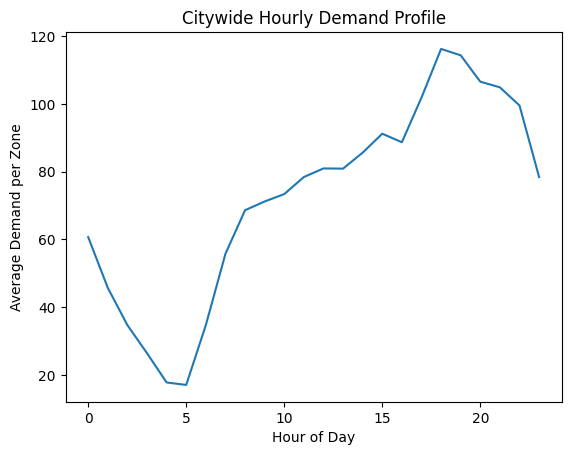

In [18]:
# Plot demand vs hour
plt.figure()
plt.plot(hourly_profile["hour"], hourly_profile["demand"])
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand per Zone")
plt.title("Citywide Hourly Demand Profile")
plt.show()

### Citywide Hourly Demand Profile

This table summarizes average demand per zone for each hour of the day. It allows to:
- Identify peak and off-peak hours
- Validate whether demand follows expected diurnal patterns

The hourly demand curve exhibits a clear daily rhythm:
- Morning ramp-up
- Midday stabilization
- Evening peak
- Overnight trough

This pattern is consistent with known commuting and nightlife behavior, validating the temporal structure of the dataset.

In [19]:
# Mean demand by weekend flag
weekday_profile = (
    df.groupby("is_weekend")["demand"]
      .mean()
      .reset_index()
)

weekday_profile

,is_weekend,demand
0,0,74.958159
1,1,70.880614


In [22]:
# Hourly split by weekday/weekend
hourly_weektype = (
    df.groupby(["hour", "is_weekend"])["demand"]
      .mean()
      .reset_index()
)

hourly_weektype.head(20)

,hour,is_weekend,demand
0,0,0,45.045747
1,0,1,94.658655
2,1,0,28.668391
3,1,1,80.722710
4,2,0,19.285879
5,2,1,66.621696
6,3,0,14.238674
7,3,1,50.358930
8,4,0,12.553213
9,4,1,29.009949


### Weekday vs Weekend Demand

This comparison shows systematic differences between weekday and weekend demand.

Interpretation:
- Weekdays reflect commuting and business travel
- Weekends show delayed peaks and altered usage patterns

Breaking demand down by hour and weekend status reveals:
- Shifted peak times on weekends
- Lower early-morning demand
- Higher late-night demand on weekends

This supports the inclusion of a weekend indicator as a predictive feature.

In [24]:
# Mean demand per zone
zone_demand = (
    df.groupby("zone_id")["demand"]
      .mean()
      .reset_index()
      .sort_values("demand", ascending=False)
)

zone_demand.head(10)

,zone_id,demand
234,237,425.607226
158,161,419.475683
233,236,401.962483
159,162,369.717462
183,186,353.981473
227,230,353.277906
47,48,325.528949
231,234,320.364057
167,170,317.523854
139,142,308.232978


In [27]:
zone_demand.tail(20)

,zone_id,demand
56,57,1.0
29,30,1.0
102,104,1.0
112,115,1.0
108,111,1.0
107,109,1.0
4,5,1.0
103,105,1.0
1,2,1.0
211,214,1.0


In [26]:
# Variability per zone
zone_variability = (
    df.groupby("zone_id")["demand"]
      .std()
      .reset_index()
      .rename(columns={"demand": "demand_std"})
)

zone_variability.sort_values("demand_std", ascending=False).head(10)

,zone_id,demand_std
233,236,300.178450
234,237,299.591453
158,161,298.929507
159,162,256.844967
78,79,225.598385
227,230,215.915864
231,234,198.325541
139,142,197.023535
183,186,185.409125
167,170,184.282797


### Spatial Heterogeneity in Demand

Demand varies drastically across zones:
- A small number of zones dominate total ride volume.
- Many zones exhibit consistently low demand.

This spatial imbalance highlights the importance of location-aware modeling and motivates zone-specific baselines.

### Zone-Level Demand Volatility

Zones differ not only in average demand but also in variability:
- High-variance zones correspond to commercial hubs and nightlife areas.
- Low-variance zones reflect residential or low-traffic areas.

This heterogeneity motivates clustering zones and using volatility-aware modeling approaches.


In [29]:
# Demand Volatility Over Time
high_zone = zone_demand.iloc[0]["zone_id"]
low_zone = zone_demand.iloc[-1]["zone_id"]

df_high = df[df["zone_id"] == high_zone].sort_values("pickup_hour_ts")
df_low = df[df["zone_id"] == low_zone].sort_values("pickup_hour_ts")

In [30]:
df_high[["pickup_hour_ts", "demand"]].head()

,pickup_hour_ts,demand
258301,2019-01-01 00:00:00,509
258302,2019-01-01 01:00:00,497
258303,2019-01-01 02:00:00,225
258304,2019-01-01 03:00:00,93
258305,2019-01-01 04:00:00,54


In [31]:
df_low[["pickup_hour_ts", "demand"]].head()

,pickup_hour_ts,demand
190308,2019-01-06 17:00:00,1
190309,2019-01-11 17:00:00,1
190310,2019-01-14 16:00:00,1
190311,2019-01-22 14:00:00,1
190312,2019-01-26 23:00:00,1


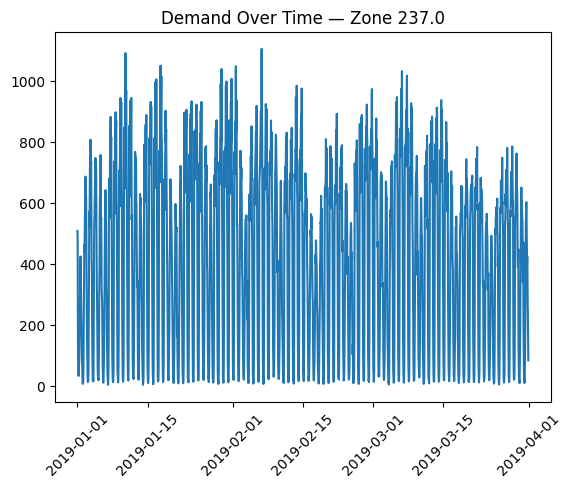

In [32]:
plt.figure()
plt.plot(df_high["pickup_hour_ts"], df_high["demand"])
plt.title(f"Demand Over Time — Zone {high_zone}")
plt.xticks(rotation=45)
plt.show()

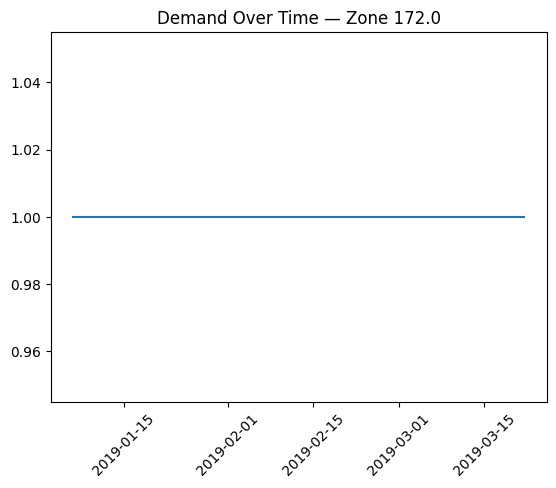

In [33]:
plt.figure()
plt.plot(df_low["pickup_hour_ts"], df_low["demand"])
plt.title(f"Demand Over Time — Zone {low_zone}")
plt.xticks(rotation=45)
plt.show()

### Temporal Demand Volatility

Time series inspection reveals:
- High-demand zones exhibit sharp peaks and rapid fluctuations.
- Low-demand zones remain relatively stable over time.

This confirms that demand dynamics differ significantly across zones and supports:
- Zone-specific forecasting models
- Hierarchical or mixed-effects modeling

## Descriptive Statistics Summary

Key findings:
- Taxi demand is highly skewed across zone-hour combinations.
- Most zones experience low hourly demand, with rare but extreme peaks.
- Demand follows a clear diurnal pattern:
  - Morning rise
  - Midday plateau
  - Evening peak
  - Overnight trough
- Weekend demand differs systematically from weekday demand.
- Spatial heterogeneity is strong:
  - A small number of zones dominate overall demand.
  - Some zones are consistently low-activity.
- Volatility varies substantially by zone, indicating different mobility roles.

These patterns justify:
- Time-based feature engineering
- Zone-specific modeling
- Use of robust evaluation metrics
